## **Import libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#TODO: SAVE EACH MODEL

## **Upload dataset**

In [ ]:
dataset = pd.read_csv('DSL-StrongPasswordData.csv')
dataset = dataset.drop(columns=['sessionIndex', 'rep'])

# Map subjects to numbers
subject_mapping = {}
unique_subjects = dataset['subject'].unique()
for i, subject in enumerate(unique_subjects):
    subject_mapping[subject] = i

dataset['subject'] = dataset['subject'].map(subject_mapping)

# 20400 x 34 
# print(dataset.iloc[0:1,:])

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into users and impostors
num_classes = len(np.unique(dataset['subject']))

user = {}
impostor = {}
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for i in range(num_classes):
    user[i] = dataset.loc[dataset['subject'] == i]
    impostor[i] = dataset.loc[dataset['subject'] != i]
    # scale impostor to the same size as user
    impostor[i] = impostor[i].sample(n=len(user[i]))

    user[i].loc[:, 'subject'] = 0
    impostor[i].loc[:, 'subject'] = 1

    merged_data = pd.concat([user[i], impostor[i]])
    
    X = merged_data.loc[:, 'H.period':'H.Return']
    y = merged_data['subject']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

#### Hold Duration, Down-Down Duration and Up-Down Duration plots

/Users/zpietrza/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/zpietrza/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/zpietrza/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/zpietrza/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 11.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/zpietrza/anaconda3/lib/python3.11/site-packages/se

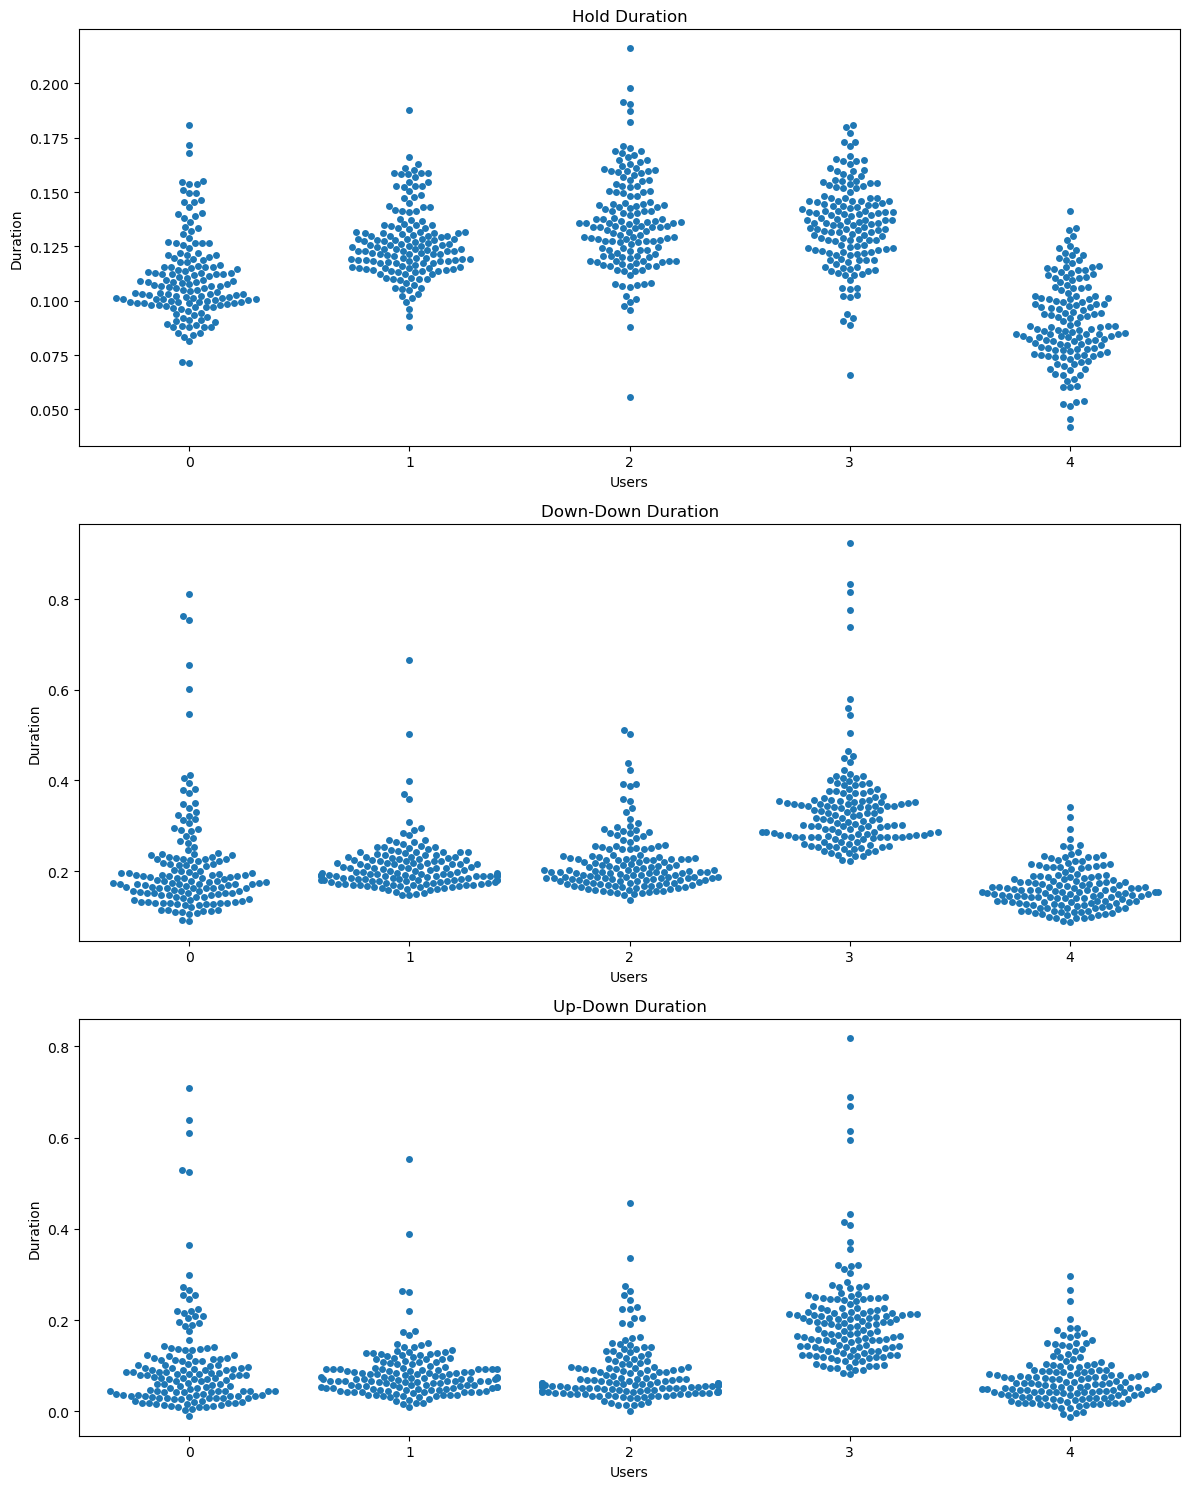

In [24]:
import seaborn as sns

unique_subjects = dataset['subject'].unique()
selected_subjects = unique_subjects[:5]

# Randomly select one row for each of the unique subjects
selected_data = dataset[dataset['subject'].isin(selected_subjects)].groupby('subject').sample(150)

fig, axes = plt.subplots(3, 1, figsize=(12, 15))
subplot_names = ["Hold Duration", "Down-Down Duration", "Up-Down Duration"]

for i, (col_name, marker) in enumerate([("H.Shift.r", 'o'), ("DD.Shift.r.o", 'o'), ("UD.Shift.r.o", 'o')]):
    ax = axes[i]
    ax.set_title(subplot_names[i]) 
    ax.set_xlabel('Users')
    ax.set_ylabel('Duration')

    # Create a subset of data with only the selected feature
    subset_data = selected_data[['subject', col_name]]

    sns.swarmplot(data=subset_data, x='subject', y=col_name, ax=ax, marker=marker)

plt.tight_layout()
plt.show()


#### Feature importance

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 30)

extra_tree_forest.fit(X, y)

feature_importance = extra_tree_forest.feature_importances_

feature_importance_normalized = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], axis = 0)

plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance_normalized)
plt.xticks(rotation=70)

plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.tight_layout()
plt.show()

# **Random Forest**

### Hyperparameters tuning

Randomized Search

In [30]:
from sklearn.ensemble import RandomForestClassifier
import random

best_models_random = []

hyperparams = {
        'n_estimators': np.arange(50, 150, step=10), # tested on 100-500, step=100 -> best = 100
        'max_depth': [None] + list(np.arange(10, 200, step=20)),
        'min_samples_split': np.arange(2, 20, step=2),
        'min_samples_leaf': [1, 2, 4], 
        'criterion': ['gini','entropy'],
        'max_features': ['log2', 'sqrt'],
        'bootstrap': [True, False]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:15]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier()

    random_search = RandomizedSearchCV(rf, hyperparams, cv=5, scoring='accuracy', n_jobs=-1, n_iter=20)
    random_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', random_search.best_params_)
    print('Best score: ', random_search.best_score_)

    best_model = random_search.best_estimator_
    best_models_random.append(best_model)

    # predictions = best_model.predict(X_test)

    # mse = mean_squared_error(y_test, predictions)
    # r2 = r2_score(y_test, predictions)
    # accuracy = accuracy_score(y_test, predictions)

    # print(f"Mean Squared Error: {mse}")
    # print(f"R-squared (R2): {r2}")
    # print(classification_report(y_test, predictions))

User  50
Best hyperparams: {'n_estimators': 130, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 30}
Best score:  0.9703125
User  10
Best hyperparams: {'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 150}
Best score:  0.9640625
User  43
Best hyperparams: {'n_estimators': 60, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_depth': 10}
Best score:  0.9671875
User  41
Best hyperparams: {'n_estimators': 90, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 190}
Best score:  0.9625
User  2
Best hyperparams: {'n_estimators': 80, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 190}
Best score:  0.9796875
User  45
Best hyperparams: {'n_estimators': 80, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 70}
Best score:  0.9984375
User  46
Best hyperparams: {'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 130}
Best score:  0.9859375
User  17
Best hyperparams: {'n_estimators': 50, 'mi

Grid Search

In [35]:
best_models_grid = []

hyperparams = {
        # random search did not find specific range for these
        'n_estimators': np.arange(40, 160, step=20), 
        'max_depth': [None] + list(np.arange(10, 200, step=20)),
        'min_samples_split': np.arange(2, 20, step=2), # 2
        'min_samples_leaf': [1, 2, 4],  # 2

        # selected from random search
        'criterion': ['gini'],
        'max_features': ['log2'],
        'bootstrap': [False]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:5]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier()

    grid_search = GridSearchCV(rf, hyperparams, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', grid_search.best_params_)
    print('Best score: ', grid_search.best_score_)

    best_model = grid_search.best_estimator_
    best_models_grid.append(best_model)

    # predictions = best_model.predict(X_test)

    # mse = mean_squared_error(y_test, predictions) 
    # r2 = r2_score(y_test, predictions)
    # accuracy = accuracy_score(y_test, predictions)

    # print(f"Mean Squared Error: {mse}")
    # print(f"R-squared (R2): {r2}")
    # print(classification_report(y_test, predictions))

User  50
Best hyperparams: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 110, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80}
Best score:  0.9609375
User  11
Best hyperparams: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.9609375
User  5
Best hyperparams: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 60}
Best score:  0.9609375
User  26
Best hyperparams: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.9609375
User  2
Best hyperparams: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 120}
Best score:  0.96093

### Final model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

models_rf = {}

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)

    predictions = rf.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print("User: ", i)
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared (R2): {r2}")
    print(classification_report(y_test, predictions))

User:  0
Mean Squared Error: 0.05
R-squared (R2): 0.8
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        80
           1       0.94      0.96      0.95        80

    accuracy                           0.95       160
   macro avg       0.95      0.95      0.95       160
weighted avg       0.95      0.95      0.95       160

User:  1
Mean Squared Error: 0.05625
R-squared (R2): 0.775
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        80
           1       0.93      0.96      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

User:  2
Mean Squared Error: 0.05
R-squared (R2): 0.8
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        80
           1       0.95      0.95      0.95        80

    accuracy   

# **K Nearest Neighbors**

### Hyperparameters tuning

Randomized Search

In [ ]:
from sklearn.ensemble import KNeighborsClassifier
import random

best_models_random = []

hyperparams = {
        'n_neighbors': list(range(2, 21)),
        'leaf_size': list(range(1, 31)),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2, 3]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:3]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    knn = KNeighborsClassifier()

    random_search = RandomizedSearchCV(knn, hyperparams, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
    random_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', random_search.best_params_)
    print('Best score: ', random_search.best_score_)

    best_model = random_search.best_estimator_
    best_models_random.append(best_model)

    predictions = best_model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared (R2): {r2}")
    print(classification_report(y_test, predictions))

Grid Search

In [ ]:
best_models_grid = []

hyperparams = {
    'n_neighbors': list(range(2, 21)),
    'leaf_size': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2, 3]
}

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    knn = KNeighborsClassifier()

    grid_search = GridSearchCV(knn, hyperparams, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', grid_search.best_params_)
    print('Best score: ', grid_search.best_score_)

    best_model = grid_search.best_estimator_
    best_models_grid.append(best_model)

    predictions = best_model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared (R2): {r2}")
    print(classification_report(y_test, predictions))

### Final model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

models_knn = {}

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)

    predictions = knn.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print("User: ", i)
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared (R2): {r2}")
    print(classification_report(y_test, predictions))

# **Neutral Network**

In [ ]:
%pip install tensorflow

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import f1_score

models_nn = {}

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

    model = Sequential()

    model.add(Dense(256, input_dim=31, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='leaky_relu'))
    model.add(Dropout(0.2))
    model.add(Dense(51, activation='softmax'))

    # metrics=['categorical_accuracy']) #TODO: sprawdzić czy to jest dobre
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100, verbose=2)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("User: ", i)
    predictions = model.predict(X_test)
    predictions = (predictions > 0.95).astype(int)

    f1 = f1_score(y_test, predictions, average='macro')
    print(f'F1 Score (Macro): {f1}')


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()